In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, layers
from tensorflow.keras.layers import Input, Dense, LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import warnings
warnings.filterwarnings('ignore')

## Main driver functions

In [2]:
def runif():
    return tf.random.uniform([1], dtype=tf.float32)[0]
    # return tf.constant(.8, tf.float32)

def rexp():
    return -tf.math.log(runif())

def reloid(x):
  '(sigma(x[1]), ..., sigma(x[-2]), relu(x[-1])'
  return tf.concat([
    tf.nn.sigmoid(x[:-1]),
    tf.nn.relu(x[-1:])
  ], axis=0)

# @tf.function
def R(x, theta):
  '''
  x: scalar
  theta: (3, H)
  '''
  # convert to vectors
  w = tf.expand_dims(theta,-1)[0]
  v = tf.expand_dims(theta,-1)[1]
  b = tf.expand_dims(theta,-1)[-1] 

  exp_w_v = tf.math.exp([w, v])
  ew = exp_w_v[0]
  ev = exp_w_v[1]

  x = tf.reshape(x, (1, 1))
  v0 = tf.transpose(ev) @ reloid(b)
  return tf.transpose(ev) @ reloid(ew @ x + b) - v0

# @tf.function
def Rinv(y, theta):
  x_left = 0
  w = tf.expand_dims(theta,-1)[0]
  v = tf.expand_dims(theta,-1)[1]
  b = tf.expand_dims(theta,-1)[-1]   
  # as x -> oo, R is asymyptotic to exp(v[-1] + w[-1]) x
  # fixme: calculate this exactly.
  x_right = 10 * tf.math.exp(w[-1] + v[-1])+ 10 * b[-1]
  tf.debugging.assert_greater(R(x_right, theta), y)
  for i in range(50):
    x_i = (x_left + x_right) / 2.
    y_i = R(x_i, theta)
    left = tf.cast(y_i < y, dtype=float)
    x_left = left * x_i + (1. - left) * x_left
    x_right = (1. - left) * x_i + left * x_right
  return x_i

@tf.custom_gradient
def custom_Rinv(y, theta):
  x = Rinv(y, theta)
  with tf.GradientTape() as g:
    g.watch([x, theta])
    y = R(x, theta)
  dR_dtheta, dR_dx = g.gradient(y, [theta, x])
  def grad(dx):
    return dx / dR_dx, -dx * dR_dtheta / dR_dx
  return x, grad

# custom_Rinv(tf.constant(5.), theta)

@tf.function
def gen_gaps(theta_vector, k: int,  
             theta=tf.constant(1e-4, dtype=tf.float32), 
             rho=tf.constant(1e-5, dtype=tf.float32)) -> tf.Tensor:
    '''Return k gaps sampled from genetic distribution with rate function eta.'''
    # w, v, b = tf.expand_dims(theta_vector,-1) # convert to vectors
    w = tf.expand_dims(theta_vector,-1)[0]
    v = tf.expand_dims(theta_vector,-1)[1]
    b = tf.expand_dims(theta_vector,-1)[-1] 

    z = tf.convert_to_tensor([[rexp()]])
    x = custom_Rinv(z, theta_vector)[0]  # initialize x by sampling from prior
    tf.debugging.assert_all_finite(x, 'first x')
    tf.debugging.assert_positive(x, message='gen_gaps first x')

    pos = tf.constant([0.], dtype=tf.float32)
    j = 0
    ta = tf.TensorArray(tf.float32, size=k + 2)

    while tf.less(j, k + 2):
        # x' satisfies R(x') - R(u*x) = Z => x' = Rinv(Z + R(u*x))
        u = runif()
        z = rexp()
        u_x = tf.convert_to_tensor([[u * x]])
        r_u_x = R(u_x,theta_vector) # compute R(u_x)
        x = custom_Rinv((z + r_u_x), theta_vector)[0]  # segment height
        # tf.print(z+r_u_x,"\n")
        tf.debugging.assert_all_finite(x,'second x')
        with tf.control_dependencies(
            [tf.debugging.assert_positive(x, message='gen_gaps second x')]
        ):
          pos += rexp() / (x * (theta + rho))  # length to next event
        while runif() < (theta / (theta + rho)) and tf.less(j, k + 2):
            ta = ta.write(j, pos)
            j += 1
            pos += rexp() / (x * (theta + rho))  # length to next event

    ret = ta.stack()[1:]  # first obs suffers from inspection paradox?
    diff = ret[1:] - ret[:-1]
    with tf.control_dependencies([
        tf.debugging.assert_positive(diff, message='gen_gaps diff')
    ]):
      return tf.cast(diff, tf.float64)
      # return w[0]

## real R

In [3]:
theta_real = tf.convert_to_tensor(np.random.rand(3, 3).astype(np.float32))
gen_gaps(theta_real,10)

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[10872.3125    ],
       [  602.58203125],
       [15253.61523438],
       [ 1836.14453125],
       [ 4446.48046875],
       [ 3092.765625  ],
       [ 4109.703125  ],
       [ 3910.91796875],
       [ 1601.        ],
       [15159.8671875 ]])>

In [4]:
w,v,b = tf.expand_dims(theta_real,-1)
w,v,b

(<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.40546456],
        [0.5631458 ],
        [0.23524927]], dtype=float32)>,
 <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.67065555],
        [0.60630906],
        [0.00826358]], dtype=float32)>,
 <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.7078438 ],
        [0.82278085],
        [0.00319741]], dtype=float32)>)

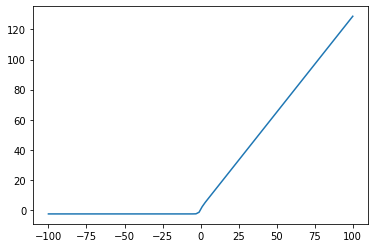

In [5]:
x = np.array([tf.constant(i,dtype=float) for i in np.linspace(-100, 100, num=100)])
y = [R(i,theta_real) for i in x]
plt.plot(x.reshape(-1),tf.reshape(y,[-1]))

## Generator


In [7]:
warnings.filterwarnings('ignore')
class CustomGenGaps(keras.layers.Layer):
  ''' Take one parameter H as input 
      Then construct one hidden layer with H units'''
  def __init__(self, H, name='gen_gaps_layer'):
      super(CustomGenGaps, self,).__init__(name=name)
      init = tf.random_normal_initializer(1)
      self.theta = self.add_weight(shape=(3,H), initializer=init, dtype='float32',
                               trainable=True,
                               constraint=tf.keras.constraints.NonNeg(),
                              #  regularizer=tf.keras.regularizers.l1_l2(0.3,0.3)
                              )

  def call(self,length):
      return tf.reshape(gen_gaps(self.theta,length),[1,length])

class Generator(keras.Model):
  ''' wrap the GenGaps layer into Keras Model '''
  def __init__(self, H):
    super(Generator, self).__init__()
    self.GenLayer = CustomGenGaps(H)

  def call(self, inputs, training=True):
    return self.GenLayer(inputs)

H = 5
generator = Generator(H)
generator(10)

<tf.Tensor: shape=(1, 10), dtype=float64, numpy=
array([[ 36218.953125, 106510.265625,  27170.46875 ,  17475.90625 ,
          2991.46875 ,  12500.      ,  97603.03125 ,  67927.28125 ,
          1718.84375 ,   6666.40625 ]])>

In [8]:
generator.get_weights()[0][...,None]

array([[[1.0683544 ],
        [0.95082414],
        [1.0043241 ],
        [1.0180955 ],
        [0.97670203]],

       [[1.0105486 ],
        [1.0861546 ],
        [1.0891719 ],
        [1.011526  ],
        [1.0039475 ]],

       [[0.9791044 ],
        [0.9500779 ],
        [0.9668321 ],
        [0.9620631 ],
        [0.9502477 ]]], dtype=float32)

In [9]:
def SSE(x):
  x = tf.cast(x, tf.float32)
  x = tf.reshape(x,[1,1])

  w = generator.get_weights()[0][...,None][0]
  b = generator.get_weights()[0][...,None][-1]
  v = generator.get_weights()[0][...,None][1]
  exp_w_v = tf.math.exp([w, v])
  ew = exp_w_v[0]
  ev = exp_w_v[1]
  v0 = tf.transpose(ev) @ reloid(b)

  r_hat = (x,generator.get_weights()[0])

  r = R(x,theta_real)
  return np.power(tf.reshape(r_hat,[-1]) - tf.reshape(r,[-1]),2) * np.exp(-x)

SSE(0.),SSE(1.)

(array([[0.]], dtype=float32), array([[23.36761]], dtype=float32))

Objective funtion

In [10]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_gaps_layer (CustomGenGap multiple                  15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Since activation of last layer of discriminator is None, I set from_logits to be True
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx)

## Comparison between real and fake $R(x)$

The code below works fine on "Real R" 

In [12]:
theta_real, generator.weights

(<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[0.40546456, 0.5631458 , 0.23524927],
        [0.67065555, 0.60630906, 0.00826358],
        [0.7078438 , 0.82278085, 0.00319741]], dtype=float32)>,
 [<tf.Variable 'Variable:0' shape=(3, 5) dtype=float32, numpy=
  array([[1.0683544 , 0.95082414, 1.0043241 , 1.0180955 , 0.97670203],
         [1.0105486 , 1.0861546 , 1.0891719 , 1.011526  , 1.0039475 ],
         [0.9791044 , 0.9500779 , 0.9668321 , 0.9620631 , 0.9502477 ]],
        dtype=float32)>])

SSE: 96.61900462148233


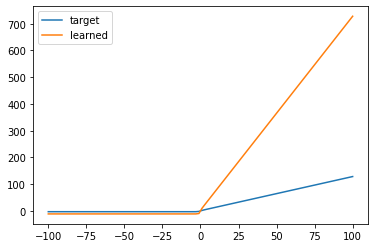

In [13]:
def performance_check(generator):
  # Real Generator Plot
  x = np.array([tf.constant(i,dtype=float) for i in np.linspace(-100, 100, num=100)])
  y = [R(i,theta_real) for i in x]
  plt.plot(x.reshape(-1),tf.reshape(y,[-1]), label='target')
  # Plot fake R
  y = [R(i,generator.weights[0]) for i in x]
  plt.plot(x.reshape(-1),tf.reshape(y,[-1]), label='learned')
  print('SSE:',integrate.quad(SSE, 0, np.inf)[0])
  plt.legend()
  plt.show()
performance_check(generator)

## discriminator

In [14]:
discriminator = keras.Sequential(
    [
     Input(shape=(10,)),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(10),
     LeakyReLU(0.2),
     Dense(1)
    ],
    name="discriminator",
)


objective function

In [15]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.8):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0
    total_loss = real_loss + fake_loss
    
    return total_loss

## Optimizer

In [16]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2,
    decay_rate=0.96,
    staircase=True)
generator_optimizer = tf.keras.optimizers.RMSprop(0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.005)

## Define trining_step

In [17]:
@tf.function
def training_step(generator, discriminator, k):
    warnings.filterwarnings('ignore')
    for _ in range(k):
         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            g_z = tf.math.log(generator(10)) / 10
            d_x_true = discriminator(tf.math.log(tf.reshape(gen_gaps(theta_real,10), (1,10))) / 10)
            d_x_fake = discriminator(g_z)

            discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
            # d_loss.append(discriminator_loss)
            # Adjusting Gradient of Discriminator
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs
            # tf.print('gradients_of_discriminator',gradients_of_discriminator)
              
            generator_loss = generator_objective(d_x_fake)
            # Adjusting Gradient of Generator
            # tf.print('generator weights',generator.trainable_variables)
            gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

            # tf.print('gradients_of_generator',gradients_of_generator)
            # weight_list = tf.concat([tf.reshape(generator.weights[0],[-1]), 
                        #  tf.reshape(generator.weights[1],[-1]), 
                        #  tf.reshape(generator.weights[2],[-1])],axis=0)
            # theoretical, numerical=tf.test.compute_gradient(f,[weight_list])
            # tf.print(theoretical, numerical)
            # print()

In [18]:
def training(epoches):
  warnings.filterwarnings('ignore')
  for epoch in range(epoches):
    training_step(generator, discriminator ,20)
    mse.append(integrate.quad(SSE, 0, np.inf)[0])
    if (epoch % 50) == 0: 
      print('epoch', epoch)
      performance_check(generator)
      # plt.plot(range(len(d_loss)),d_loss)

epoch 0
SSE: 15.827663136785798


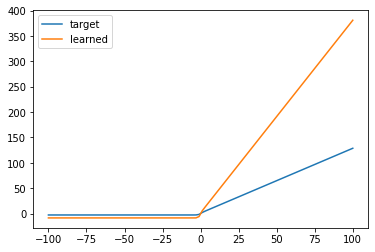

epoch 50
SSE: 11.279976253451268


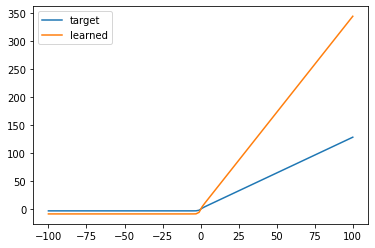

epoch 100
SSE: 7.859990974912915


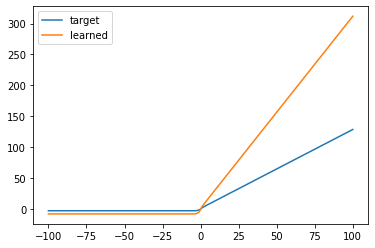

epoch 150
SSE: 5.450084762593528


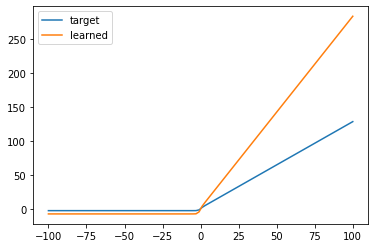

epoch 200
SSE: 3.542888233256715


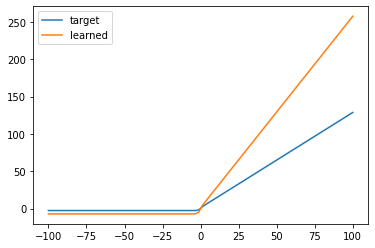

epoch 250
SSE: 2.1707500110622684


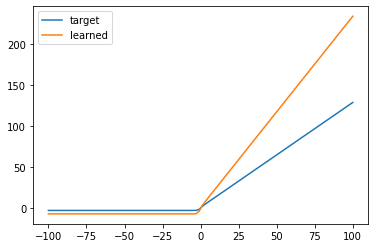

epoch 300
SSE: 1.2368007581303946


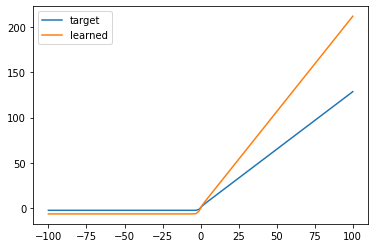

epoch 350
SSE: 0.6360425566231737


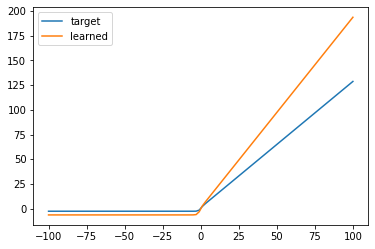

epoch 400
SSE: 0.2442561530853987


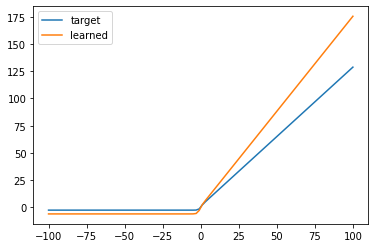

epoch 450
SSE: 0.05597705473817509


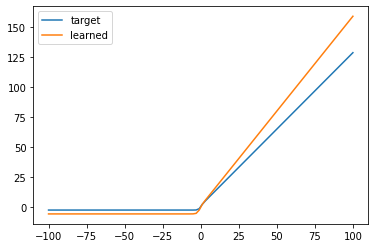

epoch 500
SSE: 0.021003417038184344


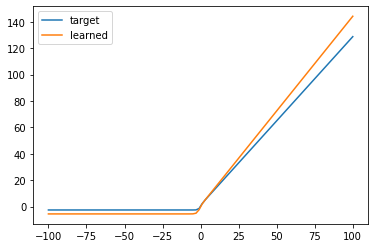

epoch 550
SSE: 0.09054631371063389


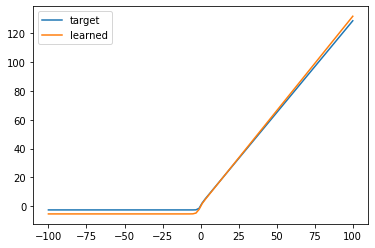

epoch 600
SSE: 0.23977329376474713


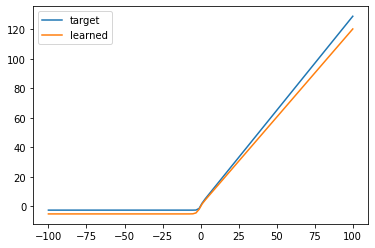

epoch 650
SSE: 0.20390453807374403


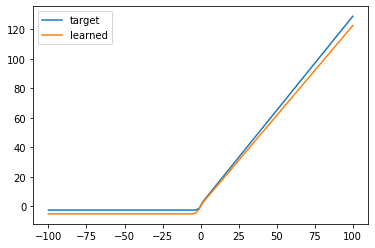

epoch 700
SSE: 0.05868379955501261


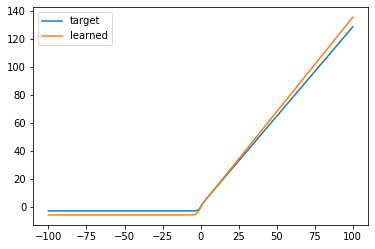

epoch 750
SSE: 0.017936739348543725


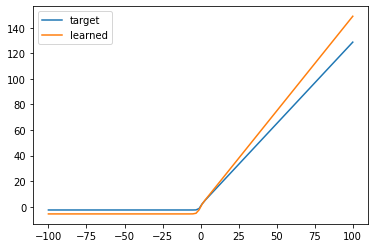

epoch 800
SSE: 0.09662653914951444


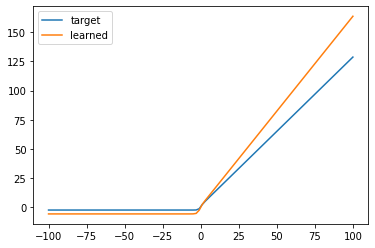

epoch 850
SSE: 0.281835292736354


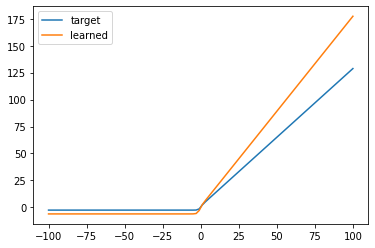

epoch 900
SSE: 0.11748036367116389


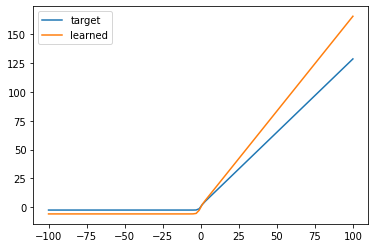

epoch 950
SSE: 0.02750286979517566


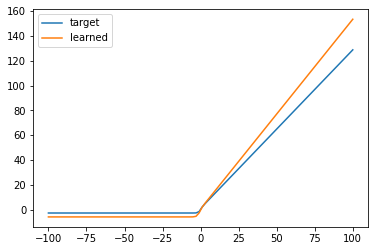

CPU times: user 31min 41s, sys: 35.2 s, total: 32min 16s
Wall time: 32min 7s


In [24]:
%%time
mse = []
EPOCHES = 1000
training(EPOCHES)

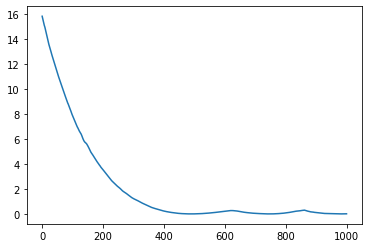

In [25]:
plt.plot(range(len(mse)),mse)